In [11]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [12]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [13]:
# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)

# Parâmetros adicionais
n = 14
d = 30
t = 14
# Lista de parâmetros n para iterar
e_list = [ 12, 13, 14, 15, 16, 17, 18, 19, 20]  # Exemplo de diferentes valores de n
alpha = 0.20  # Mantemos um único valor de alpha


price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)


price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Loop para calcular e salvar a variável para cada valor de 'e'
for e in e_list:
    # Calcula o Price Rate of Change para o valor atual de 'e'
    price_data[f'Price_Rate_Of_Change_{e}'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
        lambda x: x.pct_change(periods=e)
    )

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent


# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,Price_Rate_Of_Change_14,Price_Rate_Of_Change_15,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
11749,2024-12-04,58.400002,58.480000,56.959999,57.330002,56.822830,25109200,VALE3.SA,-1.139999,58.150667,-1.0,-0.017936,-0.027676,-0.038312,-0.050666,-0.060650,-0.065462,-0.060419,-0.062199,-0.061773,1.139999,0.000000,36.001861,57.330002,-1.0,56.84,59.380001,51.601024,-48.398976,-0.760099,-0.680823,2407909370,54.020000
11750,2024-12-05,57.459999,57.799999,56.869999,57.799999,57.288670,14160000,VALE3.SA,0.469997,58.080533,-1.0,-0.013580,-0.019120,-0.028849,-0.039472,-0.051811,-0.061782,-0.066589,-0.061552,-0.063330,0.000000,0.469997,44.510045,57.799999,-1.0,56.84,59.380001,48.839864,-51.160136,-0.747122,-0.694083,2393749370,52.660000
11751,2024-12-06,57.470001,57.660000,56.750000,56.810001,56.307430,17897900,VALE3.SA,-0.989998,57.826427,-1.0,-0.013876,-0.017896,-0.023411,-0.033098,-0.043675,-0.055959,-0.065887,-0.070673,-0.065658,0.989998,0.000000,33.160479,56.810001,-1.0,56.75,59.380001,40.928759,-59.071241,-0.748711,-0.705009,2375851470,52.320000
11752,2024-12-09,58.500000,60.189999,58.369999,59.830002,59.300713,40440600,VALE3.SA,3.020000,58.227142,-1.0,-0.003576,-0.007043,-0.011090,-0.016644,-0.026397,-0.037048,-0.049417,-0.059414,-0.064233,0.000000,3.020000,65.735648,59.830002,-1.0,56.75,60.189999,42.940186,-57.059814,-0.709459,-0.705899,2416292070,53.029999
11753,2024-12-10,59.740002,59.939999,59.290001,59.770000,59.241245,13089300,VALE3.SA,-0.060001,58.535714,-1.0,0.002584,0.001705,-0.001780,-0.005850,-0.011433,-0.021238,-0.031945,-0.044380,-0.054430,0.060001,0.000000,64.966785,59.770000,-1.0,56.75,60.189999,51.910298,-48.089702,-0.646004,-0.693920,2429381370,52.910000


In [14]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Price_Rate_Of_Change_12,Price_Rate_Of_Change_13,Price_Rate_Of_Change_14,Price_Rate_Of_Change_15,Price_Rate_Of_Change_16,Price_Rate_Of_Change_17,Price_Rate_Of_Change_18,Price_Rate_Of_Change_19,Price_Rate_Of_Change_20,down_days,up_days,RSI,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,On Balance Volume,Close_10
5716,2024-12-04,13.90,14.06,13.78,13.93,13.663173,50659000,ABEV3.SA,0.08,13.132494,-1.0,0.040662,0.041088,0.043483,0.043374,0.041790,0.036124,0.033583,0.029415,0.027859,0.00,0.08,86.876242,13.93,-1.0,12.25,14.06,48.756539,-51.243461,-0.000375,-0.063355,-2161176047,11.25
5717,2024-12-05,14.05,14.46,14.00,14.42,14.143786,38794000,ABEV3.SA,0.49,13.389995,-1.0,0.064431,0.061068,0.061502,0.063943,0.063832,0.062217,0.056441,0.053850,0.049600,0.00,0.49,90.821736,14.42,-1.0,12.25,14.46,51.583477,-48.416523,0.052492,-0.040186,-2122382047,11.02
5718,2024-12-06,14.30,14.53,14.15,14.22,13.947618,46449200,ABEV3.SA,-0.20,13.555996,-1.0,0.080194,0.077627,0.074222,0.074661,0.077133,0.077021,0.075386,0.069538,0.066915,0.20,0.00,78.976946,14.22,-1.0,12.25,14.53,57.280530,-42.719470,0.106557,-0.010837,-2075932847,11.05
5719,2024-12-09,14.22,14.33,14.14,14.21,13.937809,25321800,ABEV3.SA,-0.01,13.686797,-1.0,0.093398,0.090617,0.088025,0.084587,0.085031,0.087527,0.087413,0.085762,0.079858,0.01,0.00,78.352463,14.21,-1.0,12.25,14.53,63.017409,-36.982591,0.158135,0.022957,-2050611047,10.87
5720,2024-12-10,14.33,14.50,14.27,14.27,13.996660,22942500,ABEV3.SA,0.06,13.803438,-1.0,0.099863,0.102716,0.099911,0.097297,0.093830,0.094278,0.096795,0.096680,0.095015,0.00,0.06,79.538898,14.27,-1.0,12.25,14.53,68.133232,-31.866768,0.206047,0.059575,-2027668547,10.91


e: 12
Fold 1:
 - Correct Prediction (y_test): 60.74%
 - Correct Prediction (Verify): 59.89%
Fold 2:
 - Correct Prediction (y_test): 37.37%
 - Correct Prediction (Verify): 39.16%
Fold 3:
 - Correct Prediction (y_test): 61.58%
 - Correct Prediction (Verify): 57.47%
Fold 4:
 - Correct Prediction (y_test): 59.47%
 - Correct Prediction (Verify): 58.95%
Fold 5:
 - Correct Prediction (y_test): 48.11%
 - Correct Prediction (Verify): 49.16%
Média de acurácia (y_test) para e 12: 53.45%
Média de acurácia (Verify) para e 12: 52.93%
---
e: 13
Fold 1:
 - Correct Prediction (y_test): 60.74%
 - Correct Prediction (Verify): 59.26%
Fold 2:
 - Correct Prediction (y_test): 36.63%
 - Correct Prediction (Verify): 38.42%
Fold 3:
 - Correct Prediction (y_test): 63.05%
 - Correct Prediction (Verify): 58.53%
Fold 4:
 - Correct Prediction (y_test): 59.58%
 - Correct Prediction (Verify): 59.68%
Fold 5:
 - Correct Prediction (y_test): 48.42%
 - Correct Prediction (Verify): 49.05%
Média de acurácia (y_test) para e 

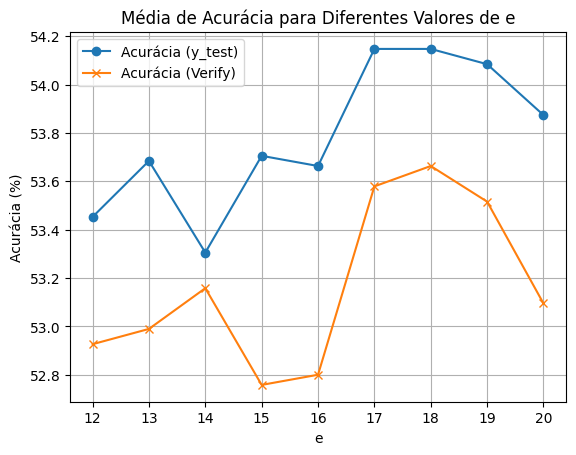

In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por e
mean_accuracy_by_e = []

# Loop para cada e em n_list e realização de validação cruzada em série temporal
for e in e_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    f'Price_Rate_Of_Change_{e}',
                    'MACD',
                    'MACD_EMA',
                    'On Balance Volume']]
    y = price_data['Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse e
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'e: {e}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por e
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_e.append((e, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para e {e}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para e {e}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for e, acc_ytest, acc_verify in mean_accuracy_by_e:
    print(f'e: {e} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por e
import matplotlib.pyplot as plt

e_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_e)

plt.plot(e_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(e_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de e")
plt.xlabel('e')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)